## Visit analysis
The purpose of this notebook is to compare the mobility of users who live in the "treatment" (ZATs near new cable car) and "control" zones (similar ZATs but no new cable car). We will map the visits we computed in the `mobility_analysis` notebook to the treatment and control group information and point of interest (POIs) computed from google places.

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

working_dir = os.getenv('WORKING_DIR')
os.environ['USE_PYGEOS'] = '0'

from setup import *
from plotting import * 
from preprocess import *
from analysis import *

import pandas as pd 
import numpy as np 
import skmob

c = read_config(f'{working_dir}configs/config_2018.yml')
(year, datatypes, initial_cols, sel_cols, final_cols, 
 minlon, maxlon, minlat, maxlat) = get_config_vars(c=c, mode='preprocess')
min_days, min_pings = get_config_vars(c=c, mode='user_qc')

where = get_dirs(working_dir, 
                 year=year, 
                 min_days=min_days, 
                 min_pings=min_pings)

meta_dir = where.meta_dir

In [19]:
#hw_dir = f'{working_dir}data/parquet/in_study_area/pass_qc/home_work_locs/'
#sel_zat_home_locs_meta_fp = f'{meta_dir}selected_txt_control_home_locs_2200_0600_w_zats_txt_group_for_users_pass_qc.csv'
#visit_dir= f'{working_dir}data/parquet/in_study_area/pass_qc/in_zats/visits/'

hw_dir = f'{where.pass_qc_dir}home_work_locs/home/'
visit_dir = f'{hw_dir}in_zats/visits/'
out_dir = f'{visit_dir}w_pois/'

for d in [visit_dir, out_dir]:
    ensure_directory_exists(d)

sel_zat_home_locs_meta_fp = f'{hw_dir}selected_txt_control_home_locs_w_zats_for_users_pass_qc_w_treatment_group.csv'

### Load home locations with ZATs and treatment group for users living in treatment and control ZATs

In [20]:

sel_zat_home_locs_meta = pd.read_csv(sel_zat_home_locs_meta_fp)
sel_zat_home_locs_meta.head()

,uid,lat_home,lng_home,Area,MUNCod,NOMMun,ZAT_home,UTAM_home,stratum,Group
0,000d4d64-39e3-4a09-8354-e9a960005fa1,4.548655,-74.09204,282837.244237,11001.0,Bogotá,649.0,UTAM50,2.009518,Control
1,1cd6278c-827c-40a4-94c4-256308945a7f,4.550887,-74.08707,282837.244237,11001.0,Bogotá,649.0,UTAM50,2.009518,Control
2,22120e28-b7e8-4c1a-aad0-966959f2f80b,4.547822,-74.08706,282837.244237,11001.0,Bogotá,649.0,UTAM50,2.009518,Control
3,2c20dec2-8d86-438e-9da8-94c71a53b3a9,4.547600,-74.08800,282837.244237,11001.0,Bogotá,649.0,UTAM50,2.009518,Control
4,3a3ed2bf-2c4d-43c2-8346-68088dffdc4a,4.547405,-74.08479,282837.244237,11001.0,Bogotá,649.0,UTAM50,2.009518,Control


### Load shapefiles with the POI information 
There is one with a buffer of 15 meters around the google places POIs and one with 20 meters buffer.

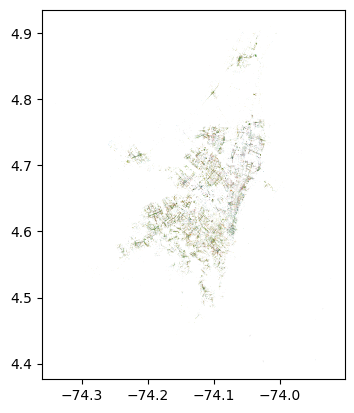

In [21]:
# for POIs with 15m Buffer
shp_name, gdf_from_shp = get_shp_to_assign_poi(shp_dir=f'{meta_dir}places/Buffer Shapefiles/', 
                                               config=c,
                                               radius=15, 
                                               plot=True)

### Load visits and map the visits to the POIs
Load the visit locations for users living within the treatment and control ZATs. Note that these are rough estimates and may need to be recomputed. 

In [24]:
visit_durations=[20, 30, 60]
min_minutes = 1e12 # or 1440

for i in tqdm(range(0,len(visit_durations)), desc=f'Mapping and writing user visits to POIs from {shp_name}'):
    stopping_time = visit_durations[i]
    visits_filename = f'users_living_in_sel_zat_visits_atleast_{stopping_time}min_nodatafor_{min_minutes}_minutes' # modify fp as needed, e.g. add _nodatafor_1440_minutes'
    visits_fp = f'{visit_dir}{visits_filename}.csv'
    outfilename = f'{visits_filename}_w_poi_from_{shp_name}_shp'
    visit_df = read_visits(visits_fp, uid_treat_group_info=sel_zat_home_locs_meta)
    visits_w_poi_df = calc_write_visit_pois(
        visit_df=visit_df, regions_gdf=gdf_from_shp, 
        cols_to_keep = (list(visit_df.columns) + ['name', 'dup', 'status', 'category', 'id', 'BUFF_DIST', 'ORIG_FID', 'Shape_Area']), 
        out_dir=out_dir, subdir_name=shp_name, outfilename=outfilename)

Mapping and writing user visits to POIs from POI_Buffer15m:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/ft/vp1_qbbs5lq2n2w83zpv4fz80000gn/T/ipykernel_76762/2285620959.py:10: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  visits_w_poi_df = calc_write_visit_pois(


There were 849473 visits in the file.
278006 instances occured where visits mapped to named POIs (some visits may map to multiple POIs).
Wrote data to users_living_in_sel_zat_visits_atleast_20min_nodatafor_1000000000000.0_minutes_w_poi_from_POI_Buffer15m_shp


/var/folders/ft/vp1_qbbs5lq2n2w83zpv4fz80000gn/T/ipykernel_76762/2285620959.py:10: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  visits_w_poi_df = calc_write_visit_pois(


There were 802928 visits in the file.
260327 instances occured where visits mapped to named POIs (some visits may map to multiple POIs).
Wrote data to users_living_in_sel_zat_visits_atleast_30min_nodatafor_1000000000000.0_minutes_w_poi_from_POI_Buffer15m_shp


/var/folders/ft/vp1_qbbs5lq2n2w83zpv4fz80000gn/T/ipykernel_76762/2285620959.py:10: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  visits_w_poi_df = calc_write_visit_pois(


There were 715628 visits in the file.
225574 instances occured where visits mapped to named POIs (some visits may map to multiple POIs).
Wrote data to users_living_in_sel_zat_visits_atleast_60min_nodatafor_1000000000000.0_minutes_w_poi_from_POI_Buffer15m_shp


#### Some logs: 
**For the 15m Buffer**
- There were 3007082 visits in the file. 1157808 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_20min_w_poi_from_POI_Buffer15m_shp
- There were 2487677 visits in the file. 934178 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_30min_w_poi_from_POI_Buffer15m_shp
- There were 1861875 visits in the file. 643682 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_60min_w_poi_from_POI_Buffer15m_shp

**For the 20m Buffer**
- There were 3007082 visits in the file. 1967679 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_20min_w_poi_from_POI_Buffer20m_shp

- There were 2487677 visits in the file. 1583775 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_30min_w_poi_from_POI_Buffer20m_shp

- There were 1861875 visits in the file. 1089400 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_60min_w_poi_from_POI_Buffer20m_shp

#### Some logs for the files with the additional `_nodatafor_1440_minutes` filtering: 

**For the 15m Buffer**
- There were 2763819 visits in the file. 1080490 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_20min_nodatafor_1440_minutes_w_poi_from_POI_Buffer15m_shp

- There were 2242918 visits in the file. 856483 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_30min_nodatafor_1440_minutes_w_poi_from_POI_Buffer15m_shp

- There were 1613447 visits in the file. 564951 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_60min_nodatafor_1440_minutes_w_poi_from_POI_Buffer15m_shp

**For the 20m Buffer**
- There were 2763819 visits in the file. 1836594 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_20min_nodatafor_1440_minutes_w_poi_from_POI_Buffer20m_shp

- There were 2242918 visits in the file. 1452026 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_30min_nodatafor_1440_minutes_w_poi_from_POI_Buffer20m_shp

- There were 1613447 visits in the file. 955859 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_60min_nodatafor_1440_minutes_w_poi_from_POI_Buffer20m_shp


### Load the visits and look at how many mapped to one or more POIs, group them by POI category

In [25]:
#outfilename = f'users_living_in_sel_zat_visits_atleast_60min_w_poi_from_{shp_name}_shp'
stopping_time = 20
outfilename = f'users_living_in_sel_zat_visits_atleast_{stopping_time}min_nodatafor_{min_minutes}_minutes_w_poi_from_{shp_name}_shp'
vists_w_poi_df_fp = f'{out_dir}{shp_name}/{outfilename}.csv'
visits_w_poi_df = pd.read_csv(vists_w_poi_df_fp)
visits_w_named_pois, visits_w_more_than_one_named_poi, grouped_category_proportions = calc_group_poi_visits(visits_w_poi_df)
visits_w_named_pois.to_csv(f'{out_dir}{shp_name}/{outfilename}_drop_null.csv', index=False)
visits_w_named_pois.head()

The number of total visits is 965073, with 278006 POIs mapped.
The number of visits that map to at least one POI is 162411, and 63022 map to multiple POIs.
The percentage of visits with more than one assigned POI is: 38.804021895068686


,uid,lat_visit,lng_visit,datetime,geohash,horizontal_accuracy,index_from_shp,LOCNombre,UTAMNombre,leaving_datetime,ZAT_home,Group,name,dup,status,category,id,BUFF_DIST,ORIG_FID,Shape_Area
1,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566299,-74.13179,2018-11-29 20:44:44-05:00,d2g3cp6bshdf,5.0,236,TUNJUELITO,TUNJUELITO,2018-11-30 07:19:50-05:00,657.0,Treatment,CITY FASHION,0.0,OPERATIONAL,cloths,15631.0,15.0,11094.0,5.747389e-08
2,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566299,-74.13179,2018-11-29 20:44:44-05:00,d2g3cp6bshdf,5.0,236,TUNJUELITO,TUNJUELITO,2018-11-30 07:19:50-05:00,657.0,Treatment,Droguería La Cincuenta y Cinco,0.0,OPERATIONAL,pharms,38458.0,15.0,26546.0,5.747386e-08
4,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.625771,-74.09745,2018-11-30 12:22:39-05:00,d2g63f5gh60s,30.0,247,PUENTE ARANDA,ZONA INDUSTRIAL,2018-11-30 13:45:18-05:00,657.0,Treatment,Banco Pichincha - Bogotá Américas,0.0,NaN,banks,9977.0,15.0,7346.0,5.747855e-08
7,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566302,-74.13179,2018-11-30 20:43:36-05:00,d2g3cp6beve8,9.0,236,TUNJUELITO,TUNJUELITO,2018-12-02 10:19:56-05:00,657.0,Treatment,CITY FASHION,0.0,OPERATIONAL,cloths,15631.0,15.0,11094.0,5.747389e-08
9,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566302,-74.13180,2018-12-02 17:47:28-05:00,d2g3cp6beug8,16.0,236,TUNJUELITO,TUNJUELITO,2018-12-03 12:03:23-05:00,657.0,Treatment,CITY FASHION,0.0,OPERATIONAL,cloths,15631.0,15.0,11094.0,5.747389e-08


### Plot proportion of category of POI visits for control and treatment ZATs

In [26]:
grouped_cat_prop_csv_fp = f'{out_dir}{outfilename}_grouped_by_txt_category_proportions'
grouped_category_proportions.to_csv(f'{grouped_cat_prop_csv_fp}.csv')
grouped_category_proportions.head()

proportion
Group   category               
Control restaurants    0.255822
        cafes          0.099357
        hgs            0.084225
        cloths         0.082794
        pharms         0.076721

In [27]:
from plotting import *

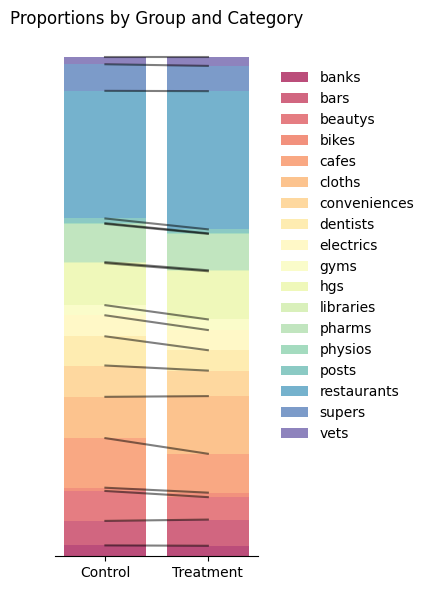

In [28]:
plotfilename = f'{where.plot_dir}users_living_in_sel_zat_visits_atleast_{stopping_time}min_w_poi_from_{shp_name}_shp_grouped_by_txt_category_proportions'
plot_stacked_bar_from_csv(f'{grouped_cat_prop_csv_fp}.csv', out_file=plotfilename, colormap='Spectral')

### Visits by month

In [29]:
visits_w_poi_df

,uid,lat_visit,lng_visit,datetime,geohash,horizontal_accuracy,index_from_shp,LOCNombre,UTAMNombre,leaving_datetime,ZAT_home,Group,name,dup,status,category,id,BUFF_DIST,ORIG_FID,Shape_Area
0,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.589577,-74.122154,2018-11-29 19:34:53-05:00,d2g6179bhxh5,5.0,191,ANTONIO NARINO,RESTREPO,2018-11-29 20:38:12-05:00,657.0,Treatment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566299,-74.131790,2018-11-29 20:44:44-05:00,d2g3cp6bshdf,5.0,236,TUNJUELITO,TUNJUELITO,2018-11-30 07:19:50-05:00,657.0,Treatment,CITY FASHION,0.0,OPERATIONAL,cloths,15631.0,15.0,11094.0,5.747389e-08
2,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566299,-74.131790,2018-11-29 20:44:44-05:00,d2g3cp6bshdf,5.0,236,TUNJUELITO,TUNJUELITO,2018-11-30 07:19:50-05:00,657.0,Treatment,Droguería La Cincuenta y Cinco,0.0,OPERATIONAL,pharms,38458.0,15.0,26546.0,5.747386e-08
3,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.626701,-74.081840,2018-11-30 07:19:50-05:00,d2g664r22p86,8.0,197,TEUSAQUILLO,QUINTA PAREDES,2018-11-30 12:10:10-05:00,657.0,Treatment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.625771,-74.097450,2018-11-30 12:22:39-05:00,d2g63f5gh60s,30.0,247,PUENTE ARANDA,ZONA INDUSTRIAL,2018-11-30 13:45:18-05:00,657.0,Treatment,Banco Pichincha - Bogotá Américas,0.0,NaN,banks,9977.0,15.0,7346.0,5.747855e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965068,fff38cbe-edac-4abd-a2b7-858d126261fa,4.567770,-74.160720,2018-07-01 10:35:31-05:00,d2g3brw48vny,11.0,46,CIUDAD BOLIVAR,JERUSALEM,2018-07-07 12:04:17-05:00,669.0,Treatment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
965069,fff38cbe-edac-4abd-a2b7-858d126261fa,4.570132,-74.163960,2018-07-07 12:04:17-05:00,d2g3brgqyqr7,12.0,46,CIUDAD BOLIVAR,JERUSALEM,2018-07-07 15:10:36-05:00,669.0,Treatment,Almacen De Ropa Jhon Eduard,1.0,NaN,cloths,3154.0,15.0,2587.0,5.747404e-08
965070,fff38cbe-edac-4abd-a2b7-858d126261fa,4.570132,-74.163960,2018-07-07 12:04:17-05:00,d2g3brgqyqr7,12.0,46,CIUDAD BOLIVAR,JERUSALEM,2018-07-07 15:10:36-05:00,669.0,Treatment,Distribuidora La Foret,1.0,OPERATIONAL,cloths,34561.0,15.0,23379.0,5.747401e-08
965071,fff38cbe-edac-4abd-a2b7-858d126261fa,4.570132,-74.163960,2018-07-07 12:04:17-05:00,d2g3brgqyqr7,12.0,46,CIUDAD BOLIVAR,JERUSALEM,2018-07-07 15:10:36-05:00,669.0,Treatment,Elohim 1 Peluqueria,1.0,OPERATIONAL,beautys,42943.0,15.0,29973.0,5.747404e-08


In [40]:
def count_visits_by_month(visit_df, cols, as_proportion=False, normalize=False, dt_col='datetime'):
    visits_to_plot = visit_df.reset_index()[cols_for_bar]
    print(f'The total number of visits considered is {len(visits_to_plot)}')
    visits_to_plot["datetime"] = pd.to_datetime(visits_to_plot["datetime"], format='mixed', dayfirst=True)
    visits_to_plot['month_name'] = visits_to_plot["datetime"].dt.month_name()
    visits_to_plot['month'] = visits_to_plot["datetime"].dt.month
    if as_proportion == False: 
        visits_grouped = visits_to_plot.groupby('month')['Group'].value_counts(dropna=False).to_frame().reset_index()
    else: 
        visits_grouped = visits_to_plot.groupby('month')['Group'].value_counts(dropna=False, normalize=True).to_frame().reset_index()
        visits_grouped['percentage'] = round(visits_grouped['proportion']*100, 2)
    if normalize == True: 
        num_users_per_month = visits_to_plot.groupby(['month', 'Group'])['uid'].nunique().to_frame().reset_index()
        normalized_visits_grouped = num_users_per_month.merge(visits_grouped['count'], left_index=True, right_index=True)
        normalized_visits_grouped['count_normalized_nusers'] = normalized_visits_grouped['count']/normalized_visits_grouped['uid']
        visits_grouped = normalized_visits_grouped 
    return visits_to_plot, visits_grouped

cols_for_bar = ['uid', #'lat_visit', 'lng_visit', 
                'datetime', #'leaving_datetime', 
                'Group', 'name', 'category']

all_visits, all_visits_grouped = count_visits_by_month(visits_w_poi_df, cols=cols_for_bar, normalize=True)
named_poi_visits, named_visits_grouped = count_visits_by_month(visits_w_named_pois, cols=cols_for_bar, normalize=True)

The total number of visits considered is 965073
The total number of visits considered is 278006


#### Plot number of visits per month for each group

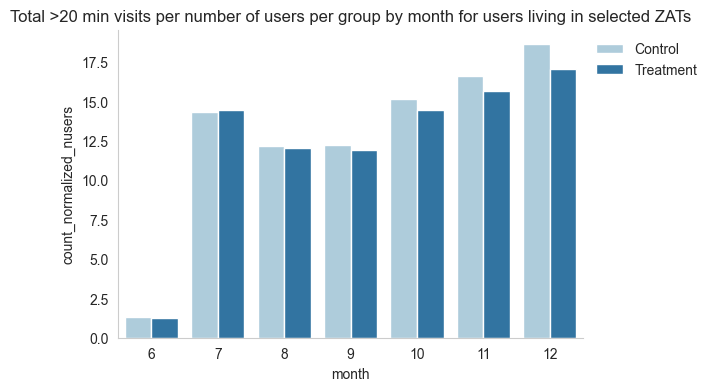

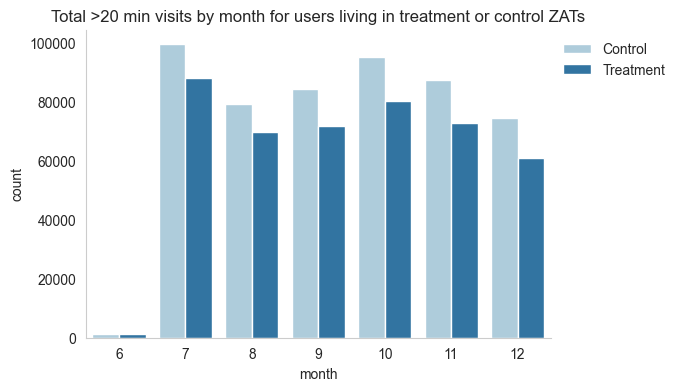

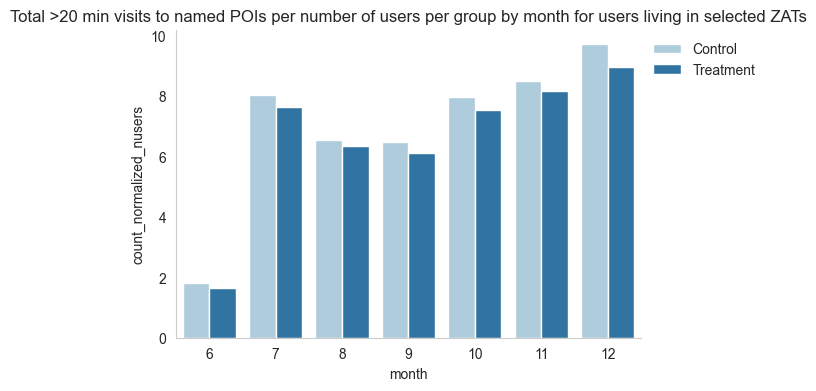

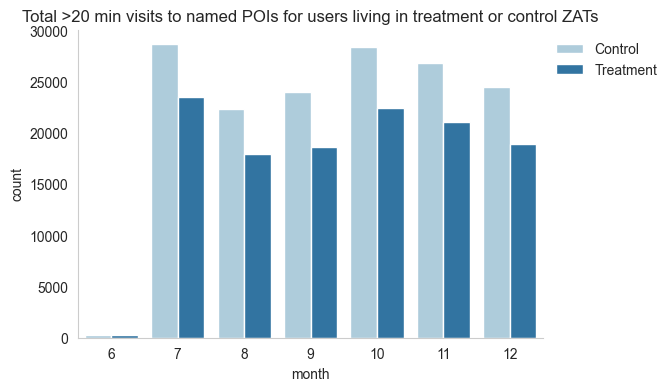

In [41]:
import seaborn as sns

def plot_visits_bar(data, x, y, hue, plot_dir, title, palette=sns.color_palette("Paired"), figsize=(10, 6)):
    sns.set_style("whitegrid", {'axes.grid': False})
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=data, 
                    x=x, y=y, hue=hue, palette=palette)

    plt.title(label=title, fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.savefig(f'{plot_dir}{title}.png', dpi=200, bbox_inches='tight')
    plt.show()


data = all_visits_grouped #[all_visits_grouped['month']<12]
plot_dir = where.plot_dir
palette = sns.color_palette("Paired")

title = f'Total >{stopping_time} min visits per number of users per group by month for users living in selected ZATs'
plot_visits_bar(
    data=data, x='month', y='count_normalized_nusers', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))

title = f'Total >{stopping_time} min visits by month for users living in treatment or control ZATs'
plot_visits_bar(
    data=data, 
    x='month', y='count', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))

data = named_visits_grouped#[named_visits_grouped['month']<12]

title = f'Total >{stopping_time} min visits to named POIs per number of users per group by month for users living in selected ZATs'
plot_visits_bar(
    data=data, x='month', y='count_normalized_nusers', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))

title = f'Total >{stopping_time} min visits to named POIs for users living in treatment or control ZATs'
plot_visits_bar(
    data=data, 
    x='month', y='count', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))


#### Plot the percentage of montly visits that come from control group users versus treatment group users

In [42]:
all_visits_p, all_visits_grouped_p = count_visits_by_month(visits_w_poi_df, cols=cols_for_bar, as_proportion=True)
named_poi_visits_p, named_visits_grouped_p = count_visits_by_month(visits_w_named_pois, cols=cols_for_bar, as_proportion=True)

The total number of visits considered is 965073
The total number of visits considered is 278006


Note: For the 2019 data, we may want to merge the 2018 and 2019 files. But otherwise I didn't count the datapoints from the last day of December 2018 in the 2019 data by filtering like `all_visits_grouped_p[all_visits_grouped_p['month']<12]`

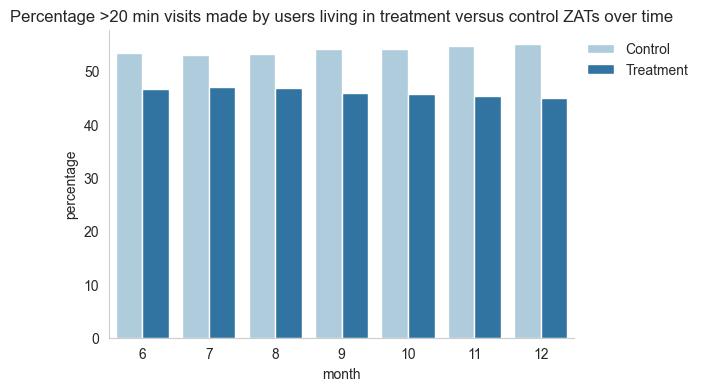

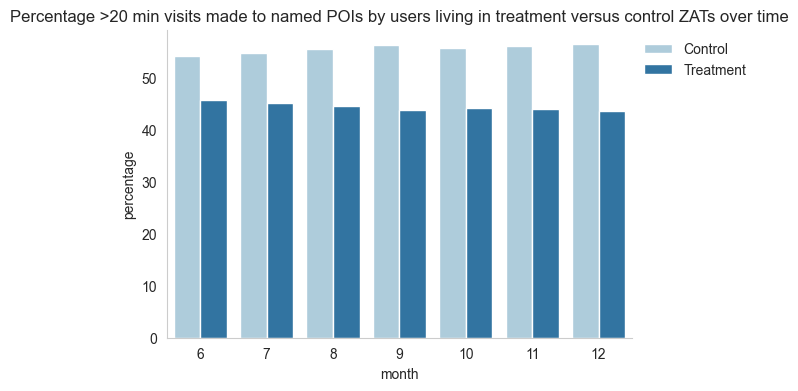

In [43]:
data = all_visits_grouped_p#[all_visits_grouped_p['month']<12]
title = f'Percentage >{stopping_time} min visits made by users living in treatment versus control ZATs over time'
plot_visits_bar(
    data=data, x='month', y='percentage', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))

data = named_visits_grouped_p#[named_visits_grouped_p['month']<12]
title = f'Percentage >{stopping_time} min visits made to named POIs by users living in treatment versus control ZATs over time'
plot_visits_bar(
    data=data, x='month', y='percentage', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))

### Make the same plots but only include users that have more than a particular number of visits

In [34]:
# exclude users for whom there are less than a threshold of visits 
visit_threshold = 150 
visit_df = visits_w_poi_df

def filter_users_by_minimum_visits(visit_df, visit_threshold):
    num_users = visit_df['uid'].nunique()
    visit_counts_per_uid = visit_df.groupby('uid')['datetime'].count()
    uids_w_enough_visits = list(visit_counts_per_uid[visit_counts_per_uid >= visit_threshold].index)
    visit_df = visit_df[visit_df['uid'].isin(uids_w_enough_visits)]
    num_users_filtered = visit_df['uid'].nunique()
    print(f'Visits from {num_users_filtered} of {num_users} users had at least {visit_threshold} visits.')
    return visit_df

visits_w_poi_df_filtered = filter_users_by_minimum_visits(visit_df=visits_w_poi_df, visit_threshold=150)
visits_w_named_pois_filtered = filter_users_by_minimum_visits(visit_df=visits_w_named_pois, visit_threshold=100)

Visits from 1238 of 22224 users had at least 150 visits.
Visits from 407 of 15997 users had at least 100 visits.


The total number of visits considered is 328752
The total number of visits considered is 69374


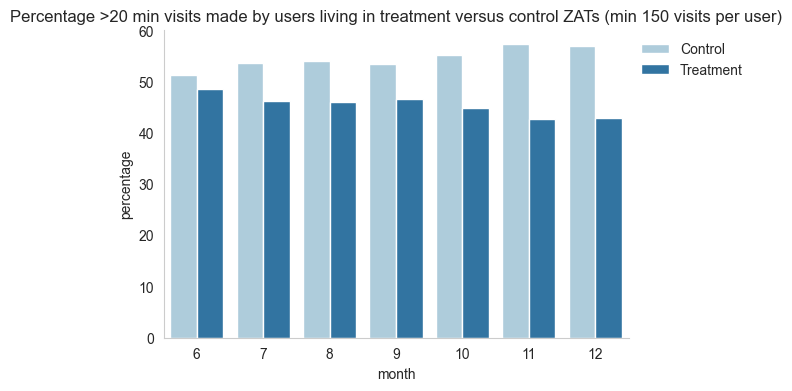

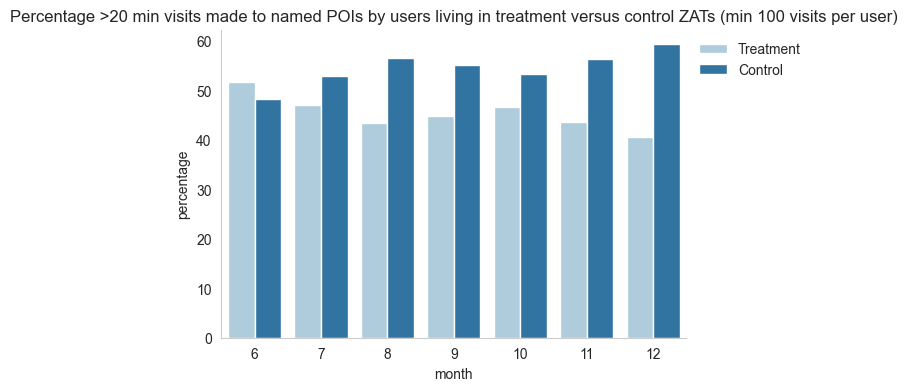

In [44]:
# compute and graph filtered data
all_visits_p, all_visits_grouped_p = count_visits_by_month(visits_w_poi_df_filtered, cols=cols_for_bar, as_proportion=True)
named_poi_visits_p, named_visits_grouped_p = count_visits_by_month(visits_w_named_pois_filtered, cols=cols_for_bar, as_proportion=True)

data = all_visits_grouped_p #[all_visits_grouped_p['month']<12]
title = f'Percentage >{stopping_time} min visits made by users living in treatment versus control ZATs (min 150 visits per user)'
plot_visits_bar(
    data=data, x='month', y='percentage', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))

data = named_visits_grouped_p #[named_visits_grouped_p['month']<12]
title = f'Percentage >{stopping_time} min visits made to named POIs by users living in treatment versus control ZATs (min 100 visits per user)'
plot_visits_bar(
    data=data, x='month', y='percentage', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))

In [37]:
### filter and then plot the normalized version of the data

The total number of visits considered is 328752
The total number of visits considered is 69374


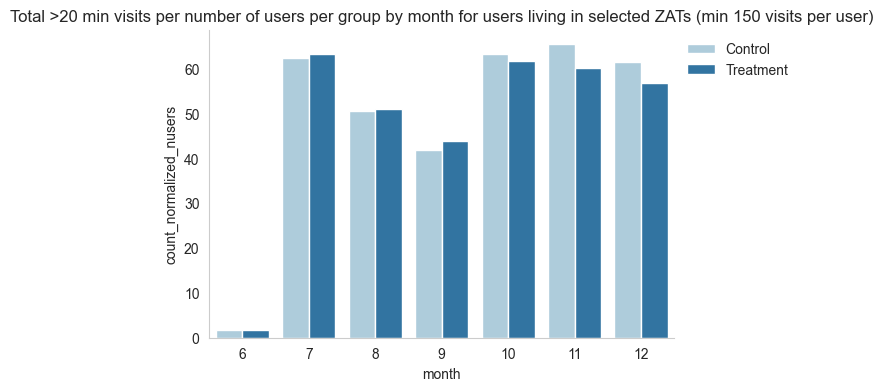

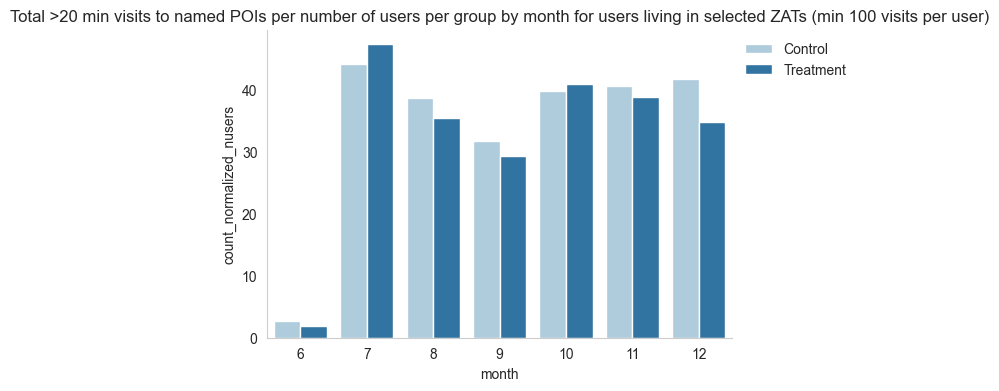

In [45]:
all_visits_p, all_visits_grouped_p = count_visits_by_month(visits_w_poi_df_filtered, cols=cols_for_bar, normalize=True)
named_poi_visits_p, named_visits_grouped_p = count_visits_by_month(visits_w_named_pois_filtered, cols=cols_for_bar, normalize=True)

data = all_visits_grouped_p #[all_visits_grouped_p['month']<12]
title = f'Total >{stopping_time} min visits per number of users per group by month for users living in selected ZATs (min 150 visits per user)'
plot_visits_bar(
    data=data, x='month', y='count_normalized_nusers', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))

data = named_visits_grouped_p #[named_visits_grouped_p['month']<12]
title = f'Total >{stopping_time} min visits to named POIs per number of users per group by month for users living in selected ZATs (min 100 visits per user)'
plot_visits_bar(
    data=data, x='month', y='count_normalized_nusers', 
    hue='Group', plot_dir=plot_dir, title=title, figsize=(6, 4))
